# CAICT 風機結冰預測 - DNN

data sampling policy 1

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

# **1. Load Data and Modules**

**Load Python modules:**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def variable_summaries(var, name):  
    with tf.name_scope('summaries_'+str(name)):  
        mean = tf.reduce_mean(var)  
        tf.summary.scalar('mean', mean)  
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))  
        tf.summary.scalar('stddev', stddev)  
        tf.summary.scalar('max', tf.reduce_max(var))  
        tf.summary.scalar('min', tf.reduce_min(var))  
        tf.summary.histogram('histogram', var)  
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}


In [3]:
def load_resample_data(id, remove_unknown=True, split_case=20, split_validation=True, policy=1):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    if remove_unknown:
        data_resample = data_resample[data_resample['label']!=2]
    
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]

    train_aX = data_resample.drop(['label','time','group','timestamp','event'], axis=1).values
    train_ay = data_resample['label'].values.astype(int)
    train_aY = np.eye(2)[train_ay]
    
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1).values
    train_y = data_resample_train['label'].values.astype(int)
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1).values
    valid_y = data_resample_valid['label'].values.astype(int)
    train_Y = np.eye(2)[train_y]
    valid_Y = np.eye(2)[valid_y]

    train_abnormal = data_resample_train[data_resample_train['label']==1]
    train_normal = data_resample_train[data_resample_train['label']==0]
    train_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(train_normal), j=len(train_normal)/len(data_resample_train),k=len(train_abnormal),m=len(train_abnormal)/len(data_resample_train), n=len(data_resample_train))
    
    valid_abnormal = data_resample_valid[data_resample_valid['label']==1]
    valid_normal = data_resample_valid[data_resample_valid['label']==0]
    valid_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(valid_normal), j=len(valid_normal)/len(data_resample_valid),k=len(valid_abnormal),m=len(valid_abnormal)/len(data_resample_valid), n=len(data_resample_valid))
    if split_validation:
        return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc
    else:
        return data_resample, train_aX, train_aY, train_ay

def load_test1_data(id,remove_unknown=True, dropna=True):
    filename = 'data/goodformat_{ID}.csv'.format(ID=id)
    data_raw = pd.read_csv(filename)
    if dropna:
        data_raw = data_raw.dropna()
    else: 
        data_raw = data_raw.fillna(0)
    
    data_X = data_raw.drop(['label','time','group','timestamp'], axis=1).values
    data_y = data_raw['label'].values.astype(int)
    data_Y = np.eye(2)[data_y]
    
    data_abnormal = data_raw[data_raw['label']==1]
    data_normal = data_raw[data_raw['label']==0]
    data_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data_raw),k=len(data_abnormal),m=len(data_abnormal)/len(data_raw), n=len(data_raw))
    
    return data_raw, data_X, data_Y, data_y, data_desc

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp.values
    return test_data, test_X, test_timeidx

    

**Load input data.** 

In [52]:
train_raw, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc = load_resample_data(id=15)
valid_raw, valid_21_X, valid_21_Y, valid_21_y, valid_21_desc= load_test1_data(id=21)
test_raw, test_X,test_timeidx = load_test2_data()

**風機15 Training Data 狀態正常(0)/異常(1)比例 **

In [53]:
print(train_desc)

正常:35339 (0.61 percent), 結冰:22179 (0.39 percent), Total:57518


**風機15  Validation Data 狀態正常(0)/異常(1)比例 **

In [76]:
print(valid_desc)

正常:7680 (0.64 percent), 結冰:4315 (0.36 percent), Total:11995


** 風機21 Testing Data 狀態正常(0)/異常(1)比例 **

In [77]:
print(valid_21_desc)

正常:168930 (0.94 percent), 結冰:10638 (0.06 percent), Total:179568


## 3. Deep Learning

### 3.1 Tensorflow 參數定義

In [78]:
n_inputs = len(train_X[1]) # 每一行的维度
n_classes = len(train_Y[1])  # RNN最后的输出類別個数

tf.reset_default_graph()
X =tf.placeholder(tf.float32, [None, n_inputs], name="X")
Y_ =tf.placeholder(tf.float32, [None, n_classes], name="Y_")

W = {
    'w1': tf.Variable(tf.random_normal([n_inputs,15], stddev=0.01)),
    'w2': tf.Variable(tf.random_normal([15,7], stddev=0.01)),
    'wout': tf.Variable(tf.random_normal([7, n_classes]), name="wout")
}
#variable_summaries(W['wd1'],'wd1')
#variable_summaries(W['wd2'],'wd2')
#variable_summaries(W['out'],'out')

B = {
    'b1': tf.Variable(tf.random_normal([15])),
    'b2': tf.Variable(tf.random_normal([7])),
    'bout': tf.Variable(tf.random_normal([n_classes]), name="bout"),
}

#variable_summaries(B['bd1'],'bd1')
#variable_summaries(B['bd2'],'bd2')
#variable_summaries(B['out'],'out')

#tfdot() 不看!

### 3.2 網路結構 Network Structure

In [79]:
with tf.name_scope("Hidden_Layer1"):
    H1 = tf.matmul(X, W['w1']) + B['b1'] 
    H1 = tf.nn.relu(H1)

with tf.name_scope("Hidden_Layer2"):
    H2 = tf.matmul(H1, W['w2']) + B['b2'] # (-1, 28) matmul (28, hidden_units) => (-1, hidden_units)
    H2 = tf.nn.relu(H2)

In [80]:
with tf.name_scope('outlayer_out'):
    _pred = tf.matmul(H2, W['wout']) + B['bout']
    pred = tf.nn.softmax(_pred, name="pred")
  


### 3.3 誤差函數 Loss Function

In [81]:
with tf.name_scope('accuracy'):
    correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels=Y_))
    loss_scar = tf.summary.scalar('loss', loss)
    acc_scar = tf.summary.scalar('accuracy', accuracy)

### 3.4 Optimizer (gradient descent)

In [82]:
lr = 0.01 # learning rate
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

### 3.5 開始訓練  Start Training

In [83]:
#先創造一個session, 然後記得要init variable
init = tf.global_variables_initializer()
merged_summary_op = tf.summary.merge_all()
sess = tf.InteractiveSession()
sess.run(init)

#if not os.path.exists('tb-log_1'):
#    os.mkdir('tb-log_1')
#summary_writer_train = tf.summary.FileWriter('tb-log1/train',graph=tf.get_default_graph())
#summary_writer_validation = tf.summary.FileWriter('tb-log1/validation',graph=tf.get_default_graph())

In [84]:
# training process
epoch = 15
batch_size = 1500
total_batch= len(train_X) / batch_size
for ep in range(epoch+1):
    for i in range(int(total_batch)+1):
        rnd_idx = np.random.choice(train_X.shape[0], batch_size, replace=False)
        batch_x = train_X[rnd_idx]
        batch_y = train_Y[rnd_idx]
        _, acc_v1, loss_v1= sess.run([optimizer, accuracy,loss], feed_dict={X: batch_x, Y_:batch_y})
        #summary_writer_train.add_summary(summary, ep * total_batch + i)

    acc_v2, loss_v2= sess.run([accuracy,loss], feed_dict={X: valid_X , Y_: valid_Y})
    #summary_writer_validation.add_summary(summary, ep * total_batch + i)
    updateProgress('epoch:{x0}, batch:{x4}, train loss:{x1:.3f} acc:{x5:.3f}, test loss:{x3:.3f} acc:{x2:.3f}'.format(x0=ep,x2=round(acc_v2,3),x3=round(loss_v2,3),x4=i,x1=round(loss_v1,3), x5=round(acc_v1,3)))
    print()

epoch:0, batch:38, train loss:0.531 acc:0.748, test loss:0.546 acc:0.622
epoch:1, batch:38, train loss:0.461 acc:0.808, test loss:0.551 acc:0.672
epoch:2, batch:38, train loss:0.422 acc:0.798, test loss:0.535 acc:0.692
epoch:3, batch:38, train loss:0.380 acc:0.822, test loss:0.532 acc:0.725
epoch:4, batch:38, train loss:0.380 acc:0.821, test loss:0.555 acc:0.717
epoch:5, batch:38, train loss:0.352 acc:0.840, test loss:0.574 acc:0.718
epoch:6, batch:38, train loss:0.327 acc:0.859, test loss:0.593 acc:0.723
epoch:7, batch:38, train loss:0.363 acc:0.825, test loss:0.612 acc:0.717
epoch:8, batch:38, train loss:0.349 acc:0.831, test loss:0.616 acc:0.725
epoch:9, batch:38, train loss:0.324 acc:0.859, test loss:0.612 acc:0.728
epoch:10, batch:38, train loss:0.355 acc:0.835, test loss:0.617 acc:0.747
epoch:11, batch:38, train loss:0.335 acc:0.849, test loss:0.629 acc:0.732
epoch:12, batch:38, train loss:0.347 acc:0.843, test loss:0.649 acc:0.733
epoch:13, batch:38, train loss:0.292 acc:0.879, 

## 4. 預測與準確率評估  Evaluation 

In [112]:
threshold=0.04

#### Predict Training Data

In [113]:
acc_t = accuracy.eval({X: train_X , Y_: train_Y})
pred_t = pd.DataFrame(pred.eval({X: train_X}))
#pred_t = pred_t.apply(np.argmax,axis=1)
pred_failprop = pred_t[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pd.Series(train_y).value_counts()
pred_result.value_counts()

s,_=myscore(train_y, pred_result)

print('Accuracy:',acc_t)
print("Precision", precision_score(train_y, pred_result))
print("Recall", sk.metrics.recall_score(train_y, pred_result))
print('score',s,_)


0    35339
1    22179
dtype: int64

1.0    38893
0.0    18625
Name: 1, dtype: int64

Accuracy: 0.865938
Precision 0.56526881444
Recall 0.99125298706
score 0.756400708986 {'fn': 194, 'tn': 18431, 'fp': 16908, 'tp': 21985}


#### Predict  Validataion Data

In [114]:
# predict all X and get the accuracy
acc_v = accuracy.eval({X: valid_X , Y_: valid_Y})
pred_v = pd.DataFrame(pred.eval({X: valid_X}))
#pred_v = pred_v.apply(np.argmax,axis=1)
pred_failprop = pred_v[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pred_result.value_counts()

s,_=myscore(valid_y, pred_result)

print('Accuracy:',acc_v)
print("Precision", precision_score(valid_y, pred_result))
print("Recall", sk.metrics.recall_score(valid_y, pred_result))
print('score',s,_)


1.0    8430
0.0    3565
Name: 1, dtype: int64

Accuracy: 0.764235
Precision 0.44827995255
Recall 0.875782155272
score 0.635091598469 {'fn': 536, 'tn': 3029, 'fp': 4651, 'tp': 3779}


** Predict another machine - partial data**

In [115]:
# predict all X and get the accuracy
acc_t = accuracy.eval({X: valid_21_X , Y_: valid_21_Y})
pred_t = pd.DataFrame(pred.eval({X: valid_21_X}))
#pred_t = pred_t.apply(np.argmax,axis=1)
pred_failprop = pred_t[1]
pred_result = pred_failprop.copy()

pred_result[pred_result >threshold] = 1
pred_result[pred_result <=threshold] = 0

pred_result.value_counts()

s,_=myscore(valid_21_y, pred_result)

print('Accuracy:',acc_t)
print("Precision", precision_score(valid_21_y, pred_result))
print("Recall", sk.metrics.recall_score(valid_21_y, pred_result))
print('score',s,_)


0.0    130201
1.0     49367
Name: 1, dtype: int64

Accuracy: 0.924536
Precision 0.175805700164
Recall 0.815848843768
score 0.787495841999 {'fn': 1959, 'tn': 128242, 'fp': 40688, 'tp': 8679}


#### Predict Test Data

In [102]:
pred_T = pd.DataFrame(pred.eval({X: test_X}))
#pred_T = pred_T.apply(np.argmax,axis=1)
pred_failprop = pred_T[1]
pred_T_result = pred_failprop.copy()


pred_T_result[pred_T_result >threshold] = 1
pred_T_result[pred_T_result <=threshold] = 0

pred_T_result.value_counts()

0.0    120845
1.0     81483
Name: 1, dtype: int64

## 5. 整理預測結果, 正確上傳格式

In [103]:
startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
test_timeidx=test_timeidx.astype(int)
for i,v in enumerate(pred_T_result):
    if (v==1) & (search_start):
        startTime = test_timeidx[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx[i-1]))
len(abnormal_list)
abnormal_list[:10]


6821

[(8658, 10608),
 (10610, 10611),
 (10613, 10614),
 (10617, 10620),
 (10622, 10622),
 (10624, 10624),
 (10626, 10626),
 (10650, 10650),
 (10653, 10656),
 (10665, 10810)]

In [104]:
output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')


19

done


## Store predict result and find the best threshold

In [105]:
test_raw_N, test_N_X, test_N_Y, test_N_y, test_N_desc= load_test1_data(21, dropna=False)
test_N_desc

'正常:179856 (0.94 percent), 結冰:10638 (0.06 percent), Total:190494'

In [106]:
pred_t = pd.DataFrame(pred.eval({X: test_N_X}))
pred_t_sm = pred_t.apply(np.argmax,axis=1)

pred_failprop = pred_t[1]
%store pred_failprop
%store pred_t_sm

Stored 'pred_failprop' (Series)
Stored 'pred_t_sm' (Series)


** Find the Best Threshold ** 

In [107]:
data_target = test_raw_N.copy()

AUC: 0.880018700783


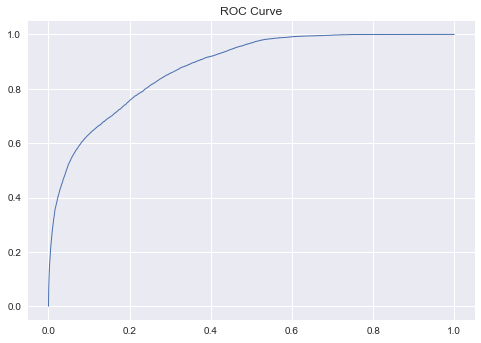

In [108]:
true_labels =data_target['label'].copy().values 
true_labels[true_labels ==2] = 0
fpr, tpr, thresholds = roc_curve(true_labels, pred_failprop)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1) 
plt.title('ROC Curve')
print('AUC:',roc_auc)
plt.show()
roc_df = pd.DataFrame({'thresholds':thresholds, 'fpr':fpr,'tpr':tpr})
roc_df = roc_df[roc_df['tpr']>0.8][:10]

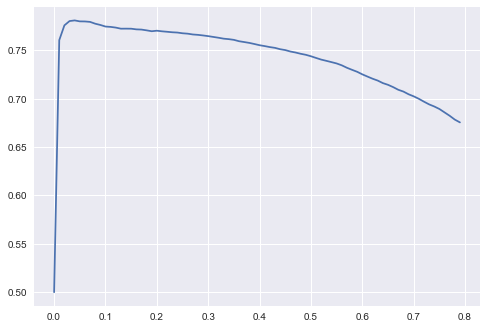

best_x: 0.04
best_score: 0.780939500613


In [111]:
x_tmp = np.arange(0., 0.8, 0.01)
y_tmp=[]
for threshold in x_tmp:
    pred_prob_tmp = pred_failprop.copy()
    pred_prob_tmp[pred_prob_tmp >threshold] = 1
    pred_prob_tmp[pred_prob_tmp <=threshold] = 0
    s,_=myscore(true_labels, pred_prob_tmp)
    y_tmp.append(s)
    del pred_prob_tmp

plt.plot(x_tmp, y_tmp) 
plt.show()
best_idx = np.argmax(y_tmp)
best_x = x_tmp[best_idx]
best_y = y_tmp[best_idx]
print('best_x:',best_x)
print('best_score:',best_y)

In [110]:
threshold = best_x
pred_prob_tmp = pred_failprop.copy()
pred_prob_tmp[pred_prob_tmp >threshold] = 1
pred_prob_tmp[pred_prob_tmp <=threshold] = 0
print("Precision", precision_score(true_labels, pred_prob_tmp))
print("Recall", sk.metrics.recall_score(true_labels, pred_prob_tmp))
s,_=myscore(true_labels, pred_prob_tmp)
print(s,_)

Precision 0.15966664827
Recall 0.815848843768
0.780939500613 {'fn': 1959, 'tn': 134178, 'fp': 45678, 'tp': 8679}


## 6. Issue
1. Data Imbalance
 - training batch sample 一半normal一半abnormal的data
 - 用兩台風機訓練兩個model, 取故障預測的聯集 

2. 用Precision & Recall評估好壞, 算出Score


other:
- using weighted examples. Just amplify the per-instance loss by a larger weight when seeing positive examples. If you use online gradient descent, it can be as simple as using a larger learning rate when seeing positive examples.
- A similar and slightly better approach (only if you use stochastic gradient descent) is randomly picking an example in each iteration, where the positive examples have higher probability of being picked.

提交结果历史记录  
参赛队伍:　556 / 参赛人数:　858  
 
|竞赛阶段	 |上传者	 |分数	 |提交日期	 |排名	 |下载|
| ---------| -------- | ------ | ------ | ------ | ------ |
|初赛test1阶段|	孔祥千	|55.28684214|	2017/7/12|	50	|下载|

Note: 7/13
1. cross correlation
2. auto correlation
3. common filter
4. de-train 